In [57]:
import os
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
from scipy.interpolate import interp1d


In [58]:
def last_time():
    stream = os.popen("source ~/OpenFOAM/OpenFOAM-v2012/etc/bashrc && foamListTimes -latestTime")
    return stream.read().rstrip()

In [59]:
print(last_time())

689.999999999444981


In [60]:
class Forces:
    def __init__(self, filename_):
        self.filename = filename_
        self.data = np.loadtxt(self.filename, delimiter="\t", skiprows=1)

    def t(self, t_star = 1):
        return self.data[:, 0]/t_star 

    def Cd(self):
        return self.data[:,1]

    def is_time_uniform(self):
        return st.stdev(self.t()) < 1e-10

    def reinterpolate(self):
        t_int = np.linspace(self.t()[0], self.t()[-1], 
                num=len(self.t()), endpoint=True)

        dt = t_int[1] - t_int[0]

        return t_int, dt, interp1d(self.t(), self.Cd(), kind='cubic') 

class AxisPlot:
    def __init__(self, filename_, names):
        self.filename = filename_
        self.data = np.loadtxt(self.filename, delimiter=",", skiprows=1)
        self.names = names

    def x(self):
        return self.data[:,0]
    
    def by_name(self, name):
        return self.c(self.names.index(name)+1)

    def c(self, num):
        return self.data[:,num]

In [61]:
# Case data
Re = 300
ff_time = 29.5

In [62]:
# Reference data
cd_paper = np.loadtxt("../../references/sphere_Re300/cd.csv", delimiter=",")
UMean_axis = np.loadtxt("../../references/sphere_Re300/UMean_axis.csv", delimiter=",")
UPrime_axis = np.loadtxt("../../references/sphere_Re300/UPrime_axis.csv", delimiter=",")

In [63]:
# File names for future writing

cd_plot = "Cd.pdf"

Text(0.5,0,'$t/T_{ff}$')

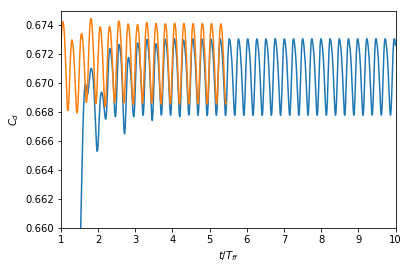

In [64]:
# Load and print forces
forces_coefs = "postProcessing/forceCoeffs1/0/coefficient.dat"
forces = Forces(forces_coefs)

f = plt.figure()
plt.ylim([0.66, 0.675])
plt.xlim([1, 10])
plt.plot(forces.t(ff_time), forces.Cd(), 
        (cd_paper[:,0] - 4.27)/ff_time, cd_paper[:,1])

plt.ylabel(r"$C_d$")
plt.xlabel(r"$t/T_{ff}$")



Strouhal number corresponding to the strongest mode: 0.1382488479263785
Paper has St = 0.136


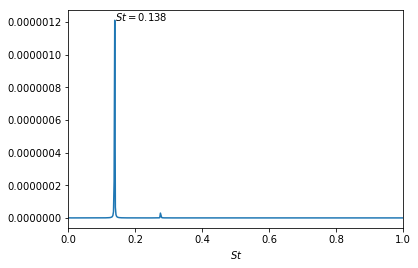

In [65]:
# Compute the FFT of the forces
t_n , dt, interpolator = forces.reinterpolate()

cd_n = interpolator(t_n)

#get only the forces after 5 flolw through time
cd_n = cd_n[t_n > 5*ff_time]
t_n = t_n[t_n > 5*ff_time]
N = len(cd_n)

freq = np.fft.rfftfreq(N, dt)

# second power for the power spectrum
pow_Cd = np.abs(np.fft.rfft(cd_n, N) / N)**2 

# strip the zeroth mode (constant)
pow_Cd = pow_Cd[1:]
freq = freq[1:]

max_value = np.amax(pow_Cd)
max_freq = freq[np.where(pow_Cd == max_value)]

f = plt.figure()
plt.plot(freq, pow_Cd)
plt.xlim([0,1])
plt.annotate("$St = {:.3f}$".format(max_freq[0]), (max_freq, max_value))
plt.xlabel("$St$")
# f.show() c


print("Strouhal number corresponding to the strongest mode: {}".format(max_freq[0]))
print("Paper has St = 0.136")



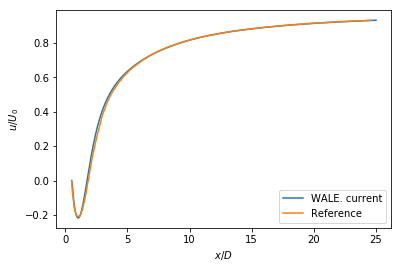

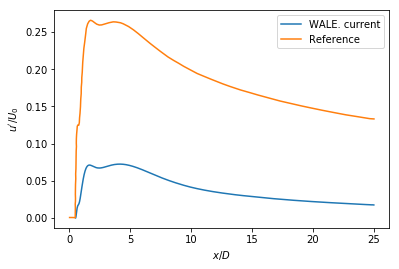

In [66]:
ax = AxisPlot("postProcessing/ax_sample/" + last_time() + "/axis_U_UMean_UPrime.csv",
    ["u_x", "u_y", "u_z", "U_x", "U_y", "U_z", "u'_x", "u'_y", "u'_z"])

f = plt.figure()
plt.plot(ax.x(), ax.by_name("U_x"), label='WALE. current')
plt.plot(UMean_axis[:,0], UMean_axis[:,1], label = "Reference")
plt.ylabel("$u/U_0$")
plt.xlabel("$x/D$")
plt.legend()
plt.show()

ax = AxisPlot("postProcessing/ax_sample/" + last_time() + "/axis_UPrime2Mean.csv",
    ["u'u'", "v'v'", "w'w'", "u'v'", "u'w'", "v'w'"])

f = plt.figure()
plt.plot(ax.x(), np.sqrt(ax.by_name("u'u'")), label='WALE. current')
plt.plot(UPrime_axis[:,0], UPrime_axis[:,1], label = "Reference")
plt.ylabel("$u'/U_0$")
plt.xlabel("$x/D$")
plt.legend()
plt.show()